# Collecting

## Videos Metadata

In [3]:
from dotenv import load_dotenv
import os
from googleapiclient.discovery import build
import scrapetube
from tqdm import tqdm
import json
from colorama import Fore, Style, init


load_dotenv() 
init()

In [4]:
youtube = build("youtube", "v3", developerKey=os.getenv("YOUTUBE_API_KEY"))

In [5]:
# getvideo_details() structers the Youtube API response

def getvideo_details(video_id):
    request = youtube.videos().list(part='snippet,contentDetails', id=video_id)
    response = request.execute()
    videoMetadata = {
        'id_video': response['items'][0]['id'],
        'id_chaine':response['items'][0]['snippet']['channelId'],
        'titre_video': response['items'][0]['snippet']['title'],
        'description':response['items'][0]['snippet']['description'],
        'date_publication':response['items'][0]['snippet']['publishedAt'],
        'duree': response['items'][0]['contentDetails']['duration'],
        'miniature':'',
        'tags':'',
        'langue':'',
        'youtubeCategorie':response['items'][0]['snippet']['categoryId'],
    }
    
    ################# get the highest resolution thumbnail
    resolution_order = ["maxres", "standard", "high", "medium", "default"]
    for res in resolution_order:
        if res in response['items'][0]['snippet']['thumbnails']:
            videoMetadata['miniature']= response['items'][0]['snippet']['thumbnails'][res]['url']
            break
    
    if 'tags' in response['items'][0]['snippet']:
        videoMetadata['tags']= response['items'][0]['snippet']['tags']
        
    if 'defaultAudioLanguage'in response['items'][0]['snippet']:
        videoMetadata['langue']= response['items'][0]['snippet']['defaultAudioLanguage']
        
    return videoMetadata

def getVideosId(listVideos):
    ids = []
    for videoDic in listVideos:
        ids.append(videoDic['id_video'])
    return ids 
   
# updateVideos() updates the videos json file with the new videos

def updateVideos(videosMetadata):
    
    print(Style.BRIGHT + Fore.GREEN + '\n Updating...')
    
    with open("../jsons/videos.json", "r", encoding="utf-8") as file:
        videos = json.load(file)
        ids = getVideosId(videos)
                
    if len(videos) == 0:
        videos.extend(videosMetadata)
    else:
        for video in videosMetadata:
            id = video['id_video']
            query = video['requete'][0]
            if id in ids:
                ###### Select the video dicionary by using the id
                videoDicionary = videos[ids.index(id)]
                videoDicionary['requete'].append(query)
            else:
                videos.append(video)
                   
    ################ Saving       
    with open("../jsons/videos.json", "w", encoding="utf-8") as f:
        print(Style.BRIGHT + Fore.YELLOW + f'\n Actual Nbr videos : {len(videos)}')
        print(Style.BRIGHT + Fore.GREEN + '\n Saving videos...')
        json.dump(videos, f, ensure_ascii=False, indent=2) 
  
# scrapeVideos() scrapes the videos given a query as input
      
def scrapeVideos(query,max_results):
    print(Style.BRIGHT + Fore.GREEN + '\nScraping Videos...')
    ############################## Scrapetube returns the videos ids relevant to a search query
    videoIds = []
    searchResults = list(scrapetube.get_search(query,limit=max_results,sort_by='relevance',results_type='video'))
    for result in searchResults:
        videoIds.append(result['videoId'])
        
    ############################## Youtube API to featch the video metadata given the ID as input
    videosMetadata = []
    for videoid in videoIds:
        videodata = getvideo_details(videoid)
        videodata['requete']=[query]
        videosMetadata.append(videodata)
    
    ############################## Update the json
    updateVideos(videosMetadata) 

    print(Style.RESET_ALL)


# Vocabulary Augmentation

## Mod√®les de Embeddings

- L'id√©e est de chercher les mots proches s√©mantiquement des termes primaires ou secondaires que nous avons d√©j√† en utilisant les embeddings de ces termes.  
- On peut faire cela avec plusieurs embedders, qui ont √©galement utile pour une extension s√©mantique par exemple :  Word2Vec, BERT, Glove...

### fasttext

pip install fasttext==0.9.3

wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.bin.gz

gunzip cc.fr.300.bin.gz

In [ ]:
! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.bin.gz

In [ ]:
! gunzip cc.fr.300.bin.gz

In [ ]:
import fasttext

modelFastext = fasttext.load_model("/teamspace/studios/this_studio/cc.fr.300.bin") 

keywords = ["Vie en autarcie", "Autosuffisance", "Fermentation","Po√™le de masse"]

for keyword in keywords:
    similar_words = modelFastext.get_nearest_neighbors(keyword, k=3)
    print(f"Expansions pour '{keyword}': {similar_words} \n")

### Word2Vec

pip install gensim==4.3.3

#### Google News model

In [ ]:
import gensim.downloader as api

modelGoogleNews = api.load("word2vec-google-news-300") 
similar_words = modelGoogleNews.most_similar("fermentation", topn=3)
print(f"Similar words to 'fermentation': {similar_words}")

#### Embedder-FrWac corpus, 1.6 billion words.

In [ ]:
! wget https://embeddings.net/embeddings/frWac_non_lem_no_postag_no_phrase_200_cbow_cut0.bin

In [ ]:
from gensim.models import KeyedVectors

model_path = 'frWac_non_lem_no_postag_no_phrase_200_cbow_cut0.bin'
modelFrench = KeyedVectors.load_word2vec_format(model_path, binary=True, unicode_errors="ignore")

mots = ["Autosuffisance", "Autonomie", "Vie en autarcie", "Potager", "Filtre Berkey", "Permaculture", 
"Filtre Doulton", "Po√™le √† bois bouilleur", "Po√™le de masse", "Cuve eau pluie", "Maison terre-paille", 
"Maison torchis", "Ferme en pierre", "Mara√Æchage", "Culture lasagnes", "Aquaponie", "Agroforesterie", 
"Forage manuel", "Puits art√©sien", "Filtration naturelle", "Biogaz maison", "Kerterre", 
"Fermentation", "Fumage"]

mots_present = 0
mots_absent = 0
mots_similaires = []

for mot in mots:
    mot_processed = mot.replace(" ", "_")
    if mot_processed in modelFrench:
        mots_present += 1
        similar_words = modelFrench.most_similar(mot_processed, topn=3)
        mots_similaires.append((mot, similar_words))
    else:
        mots_absent += 1
        print(f"Mot absent dans le mod√®le : {mot}")

pourcentage_absents = (mots_absent / len(mots)) * 100
print(f"\nPourcentage de mots absents : {pourcentage_absents:.2f}%")

for mot, similar_words in mots_similaires:
    print(f"\nMots similaires √† '{mot}':")
    for word, similarity in similar_words:
        print(f"  {word}: {similarity:.4f}")


In [ ]:
import matplotlib.pyplot as plt

labels = ['Mots pr√©sents', 'Mots absents']
sizes = [mots_present, mots_absent]
colors = ['#66b3ff', '#ff6666']
explode = (0.1, 0)

plt.figure(figsize=(7,7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('R√©partition des mots pr√©sents et absents dans le vocabulaire')
plt.show()

#### Embedder-FrWiki, 600 millions words.

In [ ]:
! wget https://embeddings.net/embeddings/frWiki_no_lem_no_postag_no_phrase_1000_cbow_cut100.bin

In [ ]:
from gensim.models import KeyedVectors

model_path = 'frWiki_no_lem_no_postag_no_phrase_1000_cbow_cut100.bin'
modelFrench = KeyedVectors.load_word2vec_format(model_path, binary=True, unicode_errors="ignore")

mots = ["Autosuffisance", "Autonomie", "Vie en autarcie", "Potager", "Filtre Berkey", "Permaculture", 
"Filtre Doulton", "Po√™le √† bois bouilleur", "Po√™le de masse", "Cuve eau pluie", "Maison terre-paille", 
"Maison torchis", "Ferme en pierre", "Mara√Æchage", "Culture lasagnes", "Aquaponie", "Agroforesterie", 
"Forage manuel", "Puits art√©sien", "Filtration naturelle", "Biogaz maison", "Kerterre", 
"Fermentation", "Fumage"]

mots_present = 0
mots_absent = 0
mots_similaires = []

for mot in mots:
    mot_processed = mot.replace(" ", "_")
    if mot_processed in modelFrench:
        mots_present += 1
        similar_words = modelFrench.most_similar(mot_processed, topn=3)
        mots_similaires.append((mot, similar_words))
    else:
        mots_absent += 1
        print(f"Mot absent du mod√®le : {mot}")

pourcentage_absents = (mots_absent / len(mots)) * 100
print(f"\nPourcentage de mots absents : {pourcentage_absents:.2f}%")

for mot, similar_words in mots_similaires:
    print(f"\nMots similaires √† '{mot}':")
    for word, similarity in similar_words:
        print(f"  {word}: {similarity:.4f}")


In [ ]:
import matplotlib.pyplot as plt

labels = ['Mots pr√©sents', 'Mots absents']
sizes = [mots_present, mots_absent]
colors = ['#66b3ff', '#ff6666']
explode = (0.1, 0)

plt.figure(figsize=(7,7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('R√©partition des mots pr√©sents et absents pour Embedder-frWiki')
plt.show()

# Discovering Plots on Collected Data

In [ ]:
import json 

with open("../jsons/videos.json", "r", encoding="utf-8") as file:
    videos = json.load(file)
    print(len(videos))

In [ ]:
import random

echantillon = random.sample(videos, min(1000, len(videos)))
with open("../jsons/echantillon.json", "w", encoding="utf-8") as f:
    json.dump(echantillon, f, ensure_ascii=False, indent=2)

## Plots for Vidoes data

In [ ]:
import json
with open("../jsons/echantillon.json", "r", encoding="utf-8") as f:
    echantillon = json.load(f)

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

categorie_labels = {
    1: "Film & Animation", 2: "Autos & Vehicles", 10: "Music", 15: "Pets & Animals", 17: "Sports",
    18: "Short Movies", 19: "Travel & Events", 20: "Gaming", 21: "Videoblogging", 22: "People & Blogs",
    23: "Comedy", 24: "Entertainment", 25: "News & Politics", 26: "Howto & Style", 27: "Education",
    28: "Science & Technology", 30: "Movies", 31: "Anime/Animation", 32: "Action/Adventure", 33: "Classics",
    34: "Comedy", 35: "Documentary", 36: "Drama", 37: "Family", 38: "Foreign", 39: "Horror",
    40: "Sci-Fi/Fantasy", 41: "Thriller", 42: "Shorts", 43: "Shows", 44: "Trailers"
}

compteur_categories = {i: 0 for i in categorie_labels.keys()}

for video in echantillon:
    cat = video.get("youtubeCategorie")
    if cat and cat.isdigit():
        cat_id = int(cat)
        if cat_id in compteur_categories:
            compteur_categories[cat_id] += 1

# Filtrage des cat√©gories avec au moins 1 vid√©o
filtre = [(i, compteur_categories[i]) for i in compteur_categories if compteur_categories[i] > 0]

# Calcul des pourcentages et tri d√©croissant
total = sum(freq for _, freq in filtre)
tri√© = sorted(filtre, key=lambda x: x[1], reverse=True)
labels = [f"{i} - {categorie_labels[i]}" for i, _ in tri√©]
frequences = [freq for _, freq in tri√©]

plt.figure(figsize=(18, 8))
bars = plt.bar(labels, frequences, color="#028ae4")
plt.xlabel("Cat√©gories YouTube")
plt.ylabel("Nombre de vid√©os")
plt.title("Nombre de vid√©os par cat√©gorie YouTube (√©chantillon tri√©)")
plt.xticks(rotation=90)

for bar, freq in zip(bars, frequences):
    pourcentage = (freq/1000)*100
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 2, f"{pourcentage:.1f}%", 
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def word_count(description):
    return len(description.split())

word_counts = [word_count(video['description']) for video in echantillon]

quartiles = np.percentile(word_counts, [25, 50, 75])
min_value = np.min(word_counts)
max_value = np.max(word_counts)

plt.figure(figsize=(10, 6))
plt.boxplot(word_counts, vert=True, patch_artist=True, boxprops=dict(facecolor="skyblue", color="blue"))

plt.xlabel('Nombre de mots', fontsize=12)
plt.title('Boxplot des longueurs de description', fontsize=14)

plt.text(1.15, min_value, f"Min: {min_value}", fontsize=12, verticalalignment='center')
plt.text(1.15, quartiles[0], f"25th percentile: {quartiles[0]}", fontsize=12, verticalalignment='center')
plt.text(1.15, quartiles[1], f"Median: {quartiles[1]}", fontsize=12, verticalalignment='center')
plt.text(1.15, quartiles[2], f"75th percentile: {quartiles[2]}", fontsize=12, verticalalignment='center')
plt.text(1.15, max_value, f"Max: {max_value}", fontsize=12, verticalalignment='center')

plt.show()


In [ ]:
import json
import matplotlib.pyplot as plt

# Charger les donn√©es JSON depuis le fichier
with open("../jsons/echantillon.json", "r", encoding="utf-8") as f:
    echantillon = json.load(f)

# Fonction pour calculer le nombre de mots dans la description
def word_count(description):
    return len(description.split())

# Obtenir le nombre de mots pour chaque description
word_counts = [word_count(video['description']) for video in echantillon]

# D√©finir les intervalles et initialiser un dictionnaire pour compter les vid√©os dans chaque intervalle
intervals = {
    'moins de 10': 0,
    '10-50': 0,
    '50-100': 0,
    '100-200': 0,
    '200-500': 0,
    'plus de 500': 0
}

# Remplir le dictionnaire avec les comptages pour chaque intervalle
for word_count_value in word_counts:
    if word_count_value < 10:
        intervals['moins de 10'] += 1
    elif 10 <= word_count_value < 50:
        intervals['10-50'] += 1
    elif 50 <= word_count_value < 100:
        intervals['50-100'] += 1
    elif 100 <= word_count_value < 200:
        intervals['100-200'] += 1
    elif 200 <= word_count_value < 500:
        intervals['200-500'] += 1
    else:
        intervals['plus de 500'] += 1

# Calculer le nombre total de vid√©os
total_videos = sum(intervals.values())

# Cr√©er l'histogramme √† partir du dictionnaire
plt.figure(figsize=(10, 6))
bars = plt.bar(intervals.keys(), intervals.values(), color='skyblue', edgecolor='black')

# Ajouter les labels et le titre
plt.xlabel('Plage de nombre de mots', fontsize=12)
plt.ylabel('Nombre de vid√©os', fontsize=12)
plt.title('Histogramme du nombre de vid√©os par plage de longueur de description', fontsize=14)

# Ajouter les pourcentages au-dessus de chaque barre
for bar in bars:
    height = bar.get_height()
    percentage = (height / total_videos) * 100
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.2, f'{percentage:.1f}%', 
             ha='center', va='bottom', fontsize=10)

# Afficher l'histogramme
plt.show()


In [ ]:
import json
import pandas as pd

# Charger les donn√©es JSON depuis le fichier
with open("../jsons/echantillon.json", "r", encoding="utf-8") as f:
    echantillon = json.load(f)

# Charger les noms des cha√Ænes depuis le fichier JSON sauvegard√©
with open("../jsons/channel_names.json", "r", encoding="utf-8") as f:
    channel_names = json.load(f)

# Comptabiliser le nombre de vid√©os par cha√Æne
video_count_per_channel = {}
for video in echantillon:
    channel_id = video['id_chaine']
    video_count_per_channel[channel_id] = video_count_per_channel.get(channel_id, 0) + 1

# Remplacer les IDs de cha√Ænes par leurs noms
channel_video_counts = {channel_names.get(channel_id, "Nom non trouv√©"): count for channel_id, count in video_count_per_channel.items()}

# Convertir en DataFrame pour un affichage sous forme de table
df_channel_video_counts = pd.DataFrame(list(channel_video_counts.items()), columns=["Nom de la cha√Æne", "Nombre de vid√©os"])

# Trier les donn√©es par nombre de vid√©os (en ordre d√©croissant)
df_channel_video_counts = df_channel_video_counts.sort_values(by="Nombre de vid√©os", ascending=False)

# Sauvegarder la table dans un fichier Excel (sans l'argument 'encoding')
df_channel_video_counts.to_excel("../xls/channel_video_counts.xlsx", index=False)

print("Le fichier Excel a √©t√© sauvegard√© sous 'channel_video_counts.xlsx'")


In [ ]:
import json
import pandas as pd
import re

# Charger les donn√©es JSON depuis le fichier
with open("../jsons/echantillon.json", "r", encoding="utf-8") as f:
    echantillon = json.load(f)

# Fonction pour convertir la dur√©e en minutes
def parse_duration(duration):
    pattern = r"PT(\d+H)?(\d+M)?(\d+S)?"
    match = re.match(pattern, duration)
    
    hours = int(match.group(1)[:-1]) if match.group(1) else 0
    minutes = int(match.group(2)[:-1]) if match.group(2) else 0
    seconds = int(match.group(3)[:-1]) if match.group(3) else 0
    
    # Conversion totale en minutes
    return (hours * 60) + minutes + (seconds / 60)

# Ajouter une colonne pour la dur√©e en minutes dans les donn√©es
for video in echantillon:
    video['duree_minutes'] = parse_duration(video['duree'])

# Cr√©er un DataFrame √† partir des donn√©es
df = pd.DataFrame(echantillon)

# Obtenir un r√©sum√© statistique des dur√©es des vid√©os en minutes
stats = df['duree_minutes'].describe()

# Convertir les statistiques en DataFrame avec les en-t√™tes horizontaux
stats_df = stats.to_frame().T  # `.T` pour transposer les statistiques en ligne

# Sauvegarder les statistiques dans un fichier Excel
output_file = "../xls/statistiques_videos.xlsx"
stats_df.to_excel(output_file, index=False)

print(f"Les statistiques ont √©t√© enregistr√©es dans {output_file}")


In [ ]:
import json
import pandas as pd
import re
import matplotlib.pyplot as plt

# Charger les donn√©es JSON depuis le fichier
with open("../jsons/echantillon.json", "r", encoding="utf-8") as f:
    echantillon = json.load(f)

# Fonction pour convertir la dur√©e en minutes
def parse_duration(duration):
    pattern = r"PT(\d+H)?(\d+M)?(\d+S)?"
    match = re.match(pattern, duration)
    
    hours = int(match.group(1)[:-1]) if match.group(1) else 0
    minutes = int(match.group(2)[:-1]) if match.group(2) else 0
    seconds = int(match.group(3)[:-1]) if match.group(3) else 0
    
    # Conversion totale en minutes
    return (hours * 60) + minutes + (seconds / 60)

# Ajouter une colonne pour la dur√©e en minutes dans les donn√©es
for video in echantillon:
    video['duree_minutes'] = parse_duration(video['duree'])

# Cr√©er un DataFrame √† partir des donn√©es
df = pd.DataFrame(echantillon)

# D√©finir les plages de dur√©es
bins = [0, 1, 5, 10, 30, 60, float('inf')]
labels = ['< 1 min', '1-5 min', '5-10 min', '10-30 min', '30-60 min', '> 60 min']

# Cr√©er une nouvelle colonne pour les plages de dur√©e
df['plage_duree'] = pd.cut(df['duree_minutes'], bins=bins, labels=labels, right=False)

# Compter le nombre de vid√©os dans chaque plage de dur√©e
count_by_range = df['plage_duree'].value_counts().sort_index()

# Calculer le pourcentage de vid√©os dans chaque plage
total_videos = len(df)
percent_by_range = (count_by_range / total_videos) * 100

# Cr√©er un histogramme
plt.figure(figsize=(10, 6))
ax = count_by_range.plot(kind='barh', color='skyblue',edgecolor='black')

# Ajouter les pourcentages au-dessus de chaque barre
for index, value in enumerate(count_by_range):
    percentage = percent_by_range[index]
    ax.text(value + 0.1, index, f'{percentage:.1f}%', va='center', ha='left', color='black')

# Ajouter les labels et titre
plt.xlabel('Nombre de vid√©os')
plt.ylabel('Plages de dur√©e')
plt.title('R√©partition des vid√©os par plage de dur√©e')
plt.xticks(rotation=0)

# Afficher le graphique
plt.show()


In [ ]:
import json
import pandas as pd

# Charger les donn√©es JSON depuis le fichier
with open("../jsons/echantillon.json", "r", encoding="utf-8") as f:
    echantillon = json.load(f)

# Extraire toutes les tags dans une liste
all_tags = []

for video in echantillon:
    tags = video.get('tags', [])
    if isinstance(tags, list):
        all_tags.extend(tags)

# Cr√©er un DataFrame √† partir des tags
tags_df = pd.DataFrame(all_tags, columns=['tag'])

# Compter la fr√©quence de chaque tag
tag_counts = tags_df['tag'].value_counts().reset_index()
tag_counts.columns = ['tag', 'frequency']

# Trier la table par fr√©quence en ordre d√©croissant
tag_counts_sorted = tag_counts.sort_values(by='frequency', ascending=False)

# Sauvegarder le r√©sultat dans un fichier Excel
tag_counts_sorted.to_excel('tag_frequencies.xlsx', index=False)

print("Tableau des fr√©quences des tags sauvegard√© dans 'tag_frequencies.xlsx'")


In [ ]:
import json
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Charger les donn√©es JSON depuis le fichier
with open("../jsons/echantillon.json", "r", encoding="utf-8") as f:
    echantillon = json.load(f)

# Extraire toutes les tags dans une liste
all_tags = []

for video in echantillon:
    tags = video.get('tags', [])
    if isinstance(tags, list):
        all_tags.extend(tags)

# Cr√©er un DataFrame √† partir des tags
tags_df = pd.DataFrame(all_tags, columns=['tag'])

# Compter la fr√©quence de chaque tag
tag_counts = tags_df['tag'].value_counts()

# Cr√©er un dictionnaire des tags et de leur fr√©quence pour la word cloud
tag_frequencies = tag_counts.to_dict()

# G√©n√©rer le nuage de mots (word cloud)
wordcloud = WordCloud(width=1200, height=800, background_color='white').generate_from_frequencies(tag_frequencies)

# Afficher le nuage de mots
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Masquer les axes
plt.show()


In [ ]:
import json
import pandas as pd
from collections import Counter

# Charger les fichiers JSON
with open("../jsons/videos.json", "r", encoding="utf-8") as f:
    videos = json.load(f)

# Compteur pour les requ√™tes
query_counter = Counter()

# Parcourir les vid√©os et compter les occurrences des requ√™tes
for video in videos:
    if 'requete' in video:
        for query in video['requete']:
            query_counter[query] += 1

# Trier les requ√™tes par fr√©quence d√©croissante
sorted_queries = sorted(query_counter.items(), key=lambda x: x[1], reverse=True)

# Cr√©er un DataFrame avec les r√©sultats
df = pd.DataFrame(sorted_queries, columns=["Requete", "Nombre d'Occurrences"])

# Sauvegarder le DataFrame dans un fichier Excel
df.to_excel("../xls/requetes_triees.xlsx", index=False)

print("Les requ√™tes ont √©t√© sauvegard√©es dans le fichier 'requetes_triees.xlsx'.")


In [ ]:
import json
from collections import defaultdict

with open("../../jsons/videos.json", "r", encoding="utf-8") as f:
    videos = json.load(f)

lang_count = defaultdict(int)

for video in videos:
    lang = video.get("langue", "unknown")
    lang_count[lang] += 1

print(f"Nombre total de vid√©os : {len(videos)}\n")
print("R√©partition par langue :")
for lang, count in lang_count.items():
    print(f"{lang} : {count}")


In [ ]:
from langdetect import detect
detect("üå± Lacampagne est un #Ecolieu d√©velopp√© par David Lecoufle qui propose une #agriculture")

## Plots for Channels data

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
with open("../../jsons/channels.json", "r", encoding="utf-8") as f:
    channels = json.load(f)
len(channels)

In [ ]:
with open("../../jsons/channelsMetrics.json", "r", encoding="utf-8") as f:
    channelsMetrics = json.load(f)
len(channelsMetrics)

### 1. Localisation plot

In [ ]:
import matplotlib.pyplot as plt

locations = [channel.get('localisation', '').strip() for channel in channels if 'localisation' in channel]
counts = {'FR': 0, 'Inconnue': 0, 'Autre': 0}
for loc in locations:
    if loc == 'FR':
        counts['FR'] += 1
    elif loc == '':
        counts['Inconnue'] += 1
    else:
        counts['Autre'] += 1

labels = ['France', 'Inconnue', 'Autre']
sizes = [counts['FR'], counts['Inconnue'], counts['Autre']]

colors = ['#4A90E2', '#7BADE2', '#A6C8E2']

plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

for text in texts:
    text.set_fontweight('bold')
    text.set_fontsize(12)
for autotext in autotexts:
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

plt.title('R√©partition des localisations des cha√Ænes YouTube', fontsize=12, fontweight='bold')
plt.axis('equal')
plt.show()


‚Äì ¬´ Autre ¬ª regroupe tous les autres pays en dehors de la France, comme les √âtats-Unis, le Canada, la Chine, etc.
- un porcentage  tres importtnat des chaines non francaise doivent etre filtr√©

### 2. Bio plot

In [ ]:
bio_lengths = [len(channel.get('bio', '').strip().split()) for channel in channels]

plt.figure(figsize=(8, 5))
plt.boxplot(bio_lengths, patch_artist=True, boxprops=dict(facecolor='#4A90E2'))

min_val = np.min(bio_lengths)
q1 = np.percentile(bio_lengths, 25)
median = np.median(bio_lengths)
q3 = np.percentile(bio_lengths, 75)
max_val = np.max(bio_lengths)

plt.title("Distribution du nombre de mots dans les bios des cha√Ænes")
plt.ylabel("Nombre de mots")
plt.grid(True)

plt.text(1.2, min_val, f'Min: {min_val}', horizontalalignment='center')
plt.text(1.2, q1, f'Q1: {q1}', horizontalalignment='center')
plt.text(1.2, median, f'Median: {median}', horizontalalignment='center')
plt.text(1.2, q3, f'Q3: {q3}', horizontalalignment='center')
plt.text(1.2, max_val, f'Max: {max_val}', horizontalalignment='center')

plt.show()


In [ ]:
df = pd.DataFrame(bio_lengths, columns=['bio_length'])

bins = [0, 1, 10, 50, 100, float('inf')]
labels = ['Pas de description', '0-10', '10-50', '50-100', '>100']
df['bio_range'] = pd.cut(df['bio_length'], bins=bins, labels=labels, right=False)

count_by_range = df['bio_range'].value_counts().sort_index()
total_bios = len(df)
percent_by_range = (count_by_range / total_bios) * 100

plt.figure(figsize=(10, 6))
ax = count_by_range.plot(kind='barh', color='skyblue', edgecolor='black')

for index, value in enumerate(count_by_range):
    percentage = percent_by_range[index]
    ax.text(value + 2, index, f'{percentage:.1f}%', va='center', ha='left', color='black', fontweight='bold')

plt.xlabel('Nombre de cha√Ænes', fontweight='bold')
plt.ylabel('Plages de longueur de bio (Nombre mots)', fontweight='bold')
plt.title('R√©partition des cha√Ænes par longueur de bio', fontweight='bold')
plt.xticks(rotation=0, fontweight='bold')
plt.yticks(fontweight='bold')

plt.show()


- Pourcentage important dss chaines sans bio (20%) donc le filtrage sementque ne marche pas

### 2. Subscribers plot

In [ ]:
abonne_counts = [channel['nombre_abonnes'] for channel in channelsMetrics]

plt.figure(figsize=(8, 5))
plt.boxplot(abonne_counts, patch_artist=True, boxprops=dict(facecolor='#4A90E2'))

min_val = np.min(abonne_counts)
q1 = np.percentile(abonne_counts, 25)
median = np.median(abonne_counts)
q3 = np.percentile(abonne_counts, 75)
max_val = np.max(abonne_counts)

plt.title("Distribution du nombre d'abonn√©s des cha√Ænes")
plt.xlabel("Nombre d'abonn√©s")
plt.grid(True)

plt.text(1, min_val, f'Min: {min_val}', horizontalalignment='center')
plt.text(1, q1, f'Q1: {q1}', horizontalalignment='center')
plt.text(1, median, f'Median: {median}', horizontalalignment='center')
plt.text(1, q3, f'Q3: {q3}', horizontalalignment='center')
plt.text(1, max_val, f'Max: {max_val}', horizontalalignment='center')

plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

abonne_counts = [channel['nombre_abonnes'] for channel in channelsMetrics]

bins = [0, 10, 100, 1000, 100000, float('inf')]
labels = ['<10', '10-100', '100-1000', '1000-100000', '>100000']

df = pd.DataFrame(abonne_counts, columns=['abonne_count'])
df['abonne_range'] = pd.cut(df['abonne_count'], bins=bins, labels=labels, right=False)

count_by_range = df['abonne_range'].value_counts().sort_index()
total_channels = len(df)
percent_by_range = (count_by_range / total_channels) * 100

plt.figure(figsize=(10, 6))
ax = count_by_range.plot(kind='barh', color='skyblue', edgecolor='black')

for index, value in enumerate(count_by_range):
    percentage = percent_by_range[index]
    ax.text(value + 2, index, f'{percentage:.1f}%', va='center', ha='left', color='black', fontweight='bold')

plt.xlabel('Nombre de cha√Ænes', fontweight='bold')
plt.ylabel('Plages de nombre d\'abonn√©s', fontweight='bold')
plt.title('R√©partition des cha√Ænes par nombre d\'abonn√©s', fontweight='bold')
plt.xticks(rotation=0, fontweight='bold')
plt.yticks(fontweight='bold')

plt.show()


In [5]:
178/211

0.8436018957345972

In [10]:
24+178

202

In [8]:
72-12+135-75+198-138+261-201+4

244

In [ ]:
video_counts = [channel['nombre_videos'] for channel in channelsMetrics]

bins = [0, 10, 50, 100, 200, float('inf')]
labels = ['<10', '10-50', '50-100', '100-200', '>200']

df = pd.DataFrame(video_counts, columns=['video_count'])
df['video_range'] = pd.cut(df['video_count'], bins=bins, labels=labels, right=False)

count_by_range = df['video_range'].value_counts().sort_index()
total_channels = len(df)
percent_by_range = (count_by_range / total_channels) * 100

plt.figure(figsize=(10, 6))
ax = count_by_range.plot(kind='barh', color='skyblue', edgecolor='black')

for index, value in enumerate(count_by_range):
    percentage = percent_by_range[index]
    ax.text(value + 2, index, f'{percentage:.1f}%', va='center', ha='left', color='black', fontweight='bold')

plt.xlabel('Nombre de cha√Ænes', fontweight='bold')
plt.ylabel('Plages de nombre de vid√©os', fontweight='bold')
plt.title('R√©partition des cha√Ænes par nombre de vid√©os', fontweight='bold')
plt.xticks(rotation=0, fontweight='bold')
plt.yticks(fontweight='bold')

plt.show()


# Shorts Analyzing

In [4]:
import json

with open("../jsons/shorts.json", "r", encoding="utf-8") as file:
    shorts = json.load(file)

In [9]:
len(shorts)

732

- Shorts With likn in the description 

In [ ]:
import re

url_pattern = re.compile(r'https?://\S+')
shorts_with_links = []

for video in shorts:
    description = video.get("description", "")
    if url_pattern.search(description):
        shorts_with_links.append(video)

with open("../jsons/shorts_with_links.json", "w", encoding="utf-8") as outfile:
    json.dump(shorts_with_links, outfile, indent=2, ensure_ascii=False)

print(f"{len(shorts_with_links)} shorts")


In [5]:
import json
import re

with open('../jsons/shorts_with_links.json', 'r', encoding='utf-8') as file:
    shorts_with_links = json.load(file)

def extract_links(description):
    return re.findall(r'https?://\S+', description)

for video in shorts_with_links:
    links = extract_links(video['description'])
    video['links'] = links

with open('../jsons/shorts_with_links.json', 'w', encoding='utf-8') as file:
    json.dump(shorts_with_links, file, indent=4, ensure_ascii=False)

print("Les liens ont √©t√© extraits et ajout√©s avec succ√®s.")


Les liens ont √©t√© extraits et ajout√©s avec succ√®s.


In [8]:
len(shorts_with_links)

229

In [7]:
import json
import re

with open('../jsons/shorts_with_links.json', 'r', encoding='utf-8') as file:
    shorts_with_links = json.load(file)

def contains_youtube_link(links):
    return any(re.search(r'https://youtu\.be/\S+', link) for link in links)

count_youtube_links = sum(1 for video in shorts_with_links if contains_youtube_link(video['links']))

print(f"Nombre de shorts contenant un lien vers une autre vid√©o YouTube : {count_youtube_links}")


Nombre de shorts contenant un lien vers une autre vid√©o YouTube : 17


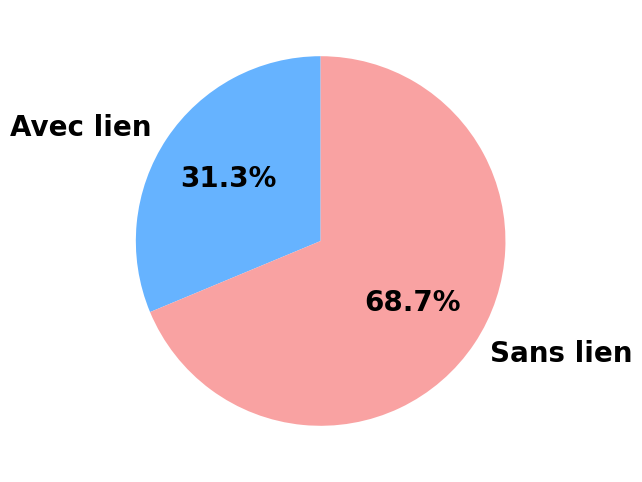

In [23]:
import matplotlib.pyplot as plt

# Donn√©es
total_shorts = 732
shorts_with_links = 229
shorts_with_youtube_links = 17
shorts_with_other_links = shorts_with_links - shorts_with_youtube_links

# Pourcentages pour le deuxi√®me camembert
youtube_link_pct = (shorts_with_youtube_links / shorts_with_links) * 100
other_links_pct = (shorts_with_other_links / shorts_with_links) * 100

# Couleurs
colors1 = ['#66b3ff', "#f9a2a2"]
colors2 = ['#99ff99', '#ffcc99']

plt.figure(figsize=(12, 6))

# Camembert 1 : Shorts avec/sans lien
wedges1, texts1, autotexts1 = plt.pie(
    [shorts_with_links, total_shorts - shorts_with_links],
    labels=['Avec lien', 'Sans lien'],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors1
)
# Mettre les labels et les pourcentages en gras
for text in texts1:
    text.set_fontweight('bold')
    text.set_fontsize(20)
for autotext in autotexts1:
    autotext.set_fontweight('bold')
    autotext.set_fontsize(20)

#plt.title('Proportion de Shorts avec ou sans lien', fontsize=20, fontweight='bold')

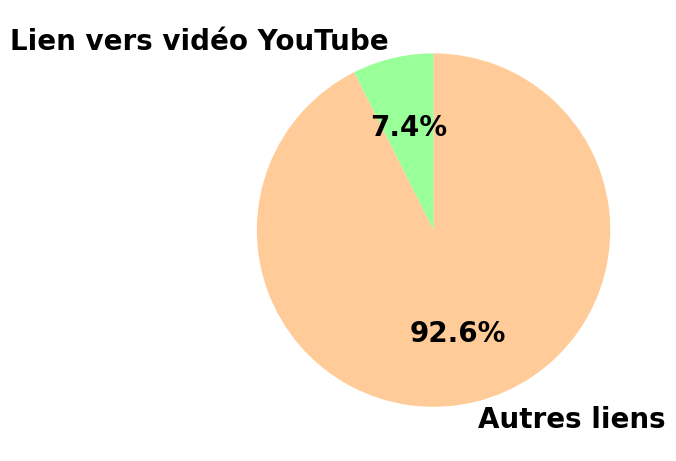

In [22]:

# Camembert 2 : Types de lien parmi les 229 avec lien
wedges2, texts2, autotexts2 = plt.pie(
    [shorts_with_youtube_links, shorts_with_other_links],
    labels=['Lien vers vid√©o YouTube', 'Autres liens'],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors2
)
# Mettre les pourcentages en gras
for autotext in autotexts2:
    autotext.set_fontweight('bold')
    autotext.set_fontsize(20)

#plt.title('R√©partition des types de liens (parmi les 31,3 %)', fontsize=20, fontweight='bold')

# Ajuster la taille des labels du deuxi√®me camembert
plt.setp(plt.gca().texts, fontweight='bold', fontsize=20)

plt.tight_layout()
plt.show()


- Shorts Without likn in the description 

In [31]:
chainesTv = [
    "France 2", "France 3", "France 4","France 5","Franceinfo"
    "BFMTV", "C8", "CStar", "Gulli", "Cnews",
    "Canal+", "Plan√®te+", "LCI", "Paris premi√®re",
    "6ter", "Arte", "M6", "W9",
    "TFX", "TMC", "NRJ12", "TF1","La Cha√Æne parlementaire",
    "Ch√©rie 25", "RMC"
]
chainesTv = [nomTV.lower().replace(" ", "") for nomTV in chainesTv]

print(len(chainesTv))
print(chainesTv)

24
['france2', 'france3', 'france4', 'france5', 'franceinfobfmtv', 'c8', 'cstar', 'gulli', 'cnews', 'canal+', 'plan√®te+', 'lci', 'parispremi√®re', '6ter', 'arte', 'm6', 'w9', 'tfx', 'tmc', 'nrj12', 'tf1', 'lacha√Æneparlementaire', 'ch√©rie25', 'rmc']


In [ ]:
import json
import re

with open('../jsons/shorts.json', 'r', encoding='utf-8') as file:
    shorts = json.load(file)

def extract_links(description):
    return re.findall(r'https?://\S+', description)

shorts_without_links = [video for video in shorts if not extract_links(video['description'])]

with open('../jsons/shorts_without_links.json', 'w', encoding='utf-8') as file:
    json.dump(shorts_without_links, file, indent=4, ensure_ascii=False)

print(f"{len(shorts_without_links)} shorts sans lien ont √©t√© extraits.")


In [ ]:
import matplotlib.pyplot as plt

categories = ['Tutoriel', 'Vlog rapide', 'Autre', 'Short explicatif']
counts = [149, 93, 165, 96]

plt.figure(figsize=(7, 7))
wedges, texts, autotexts = plt.pie(counts, labels=categories, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#99ff99', '#ffcc99', '#ff6666'])

# Mettre tout le texte en gras
for text in texts:
    text.set_fontweight('bold')
    text.set_fontsize(14)
for autotext in autotexts:
    autotext.set_fontweight('bold')
    autotext.set_fontsize(14)

plt.title('Video Categories Distribution', fontsize=16, fontweight='bold')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle.

plt.show()
